### Cat vs. dog Image Classification -- Walmy Marine

Evaluating the CNN from the previous exercise by using 1/4 of our training data as test data

#### Importing Data (Cats and Dogs images)

In [96]:
import os
import zipfile 
target = r'C:\Users\w_alm\OneDrive\Documents\Python Scripts\cats_and_dogs_filtered.zip'
if not os.path.isdir(os.path.dirname(target)):
    print("Cannot open zipfile it does not exists")
else:
    local_zip = r'C:\Users\w_alm\OneDrive\Documents\Python Scripts\cats_and_dogs_filtered.zip'
    zip_ref = zipfile.ZipFile(local_zip, 'r')
    zip_ref.extractall()
    # extractall('etc') would create a folder called 'etc' to place the extracted content of the zip file
    # but if nothing is name it would extract everything without creating folder
    zip_ref.close()

#### Creating Directories Variables

In [97]:
base_dir = 'cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our calidation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

#### Importing Pre-existing Model

In [98]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
# Download the weights of the model
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape = (150, 150, 3),
    include_top = False,
    weights = None)
pre_trained_model.load_weights(local_weights_file)

In [99]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [100]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


In [101]:
pre_model = tf.keras.models.Sequential()

pre_model.add(pre_trained_model)
pre_model.add(layers.Flatten(input_shape = last_output.shape[1:]))
# Create a fully connected layer with Relu activation and 512 hidden units
pre_model.add(layers.Dense(1024, activation = 'relu'))
# Add a dropout rate of 0.2
pre_model.add(layers.Dropout(0.2))
# Create output layer with a single node and sigmoid activation
pre_model.add(layers.Dense(1, activation = 'sigmoid'))

In [102]:
pre_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_6 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              18875392  
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 1025      
Total params: 40,679,201
Trainable params: 18,876,417
Non-trainable params: 21,802,784
_________________________________________________________________


#### Importing Pre-existing Cats and Dogs model from previous exercise

In [103]:
from tensorflow.keras.models import load_model
local_file_model= 'CATS_DOGS_model.h5'
model = load_model(local_file_model)

In [104]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

#### Preprocessing the Data

In [105]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir, # This is the source directory for training images
    target_size = (150, 150), # All images will be resized to 150x150
    batch_size = 20,
    # Since we using binary_crossntropy loss, we need binary labels
    class_mode = 'binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### Compile the Model and Train it

In [106]:
from tensorflow.keras.optimizers import RMSprop

pre_model.compile(loss = 'binary_crossentropy',
             optimizer = RMSprop(lr = 0.001),
             metrics = ['acc'])

In [142]:
history = pre_model.fit(
    train_generator,
    steps_per_epoch = 100, # 2,000 images = batch_size * steps
    epochs = 2,
    validation_data = validation_generator,
    validation_steps = 50, # 1,000 images = batch_size * steps
    verbose = 2)

Epoch 1/2
100/100 - 58s - loss: 0.4689 - acc: 0.9120 - val_loss: 0.4779 - val_acc: 0.9170
Epoch 2/2
100/100 - 58s - loss: 0.4047 - acc: 0.9235 - val_loss: 0.2457 - val_acc: 0.9560


Text(0.5, 1.0, 'Training and validation loss')

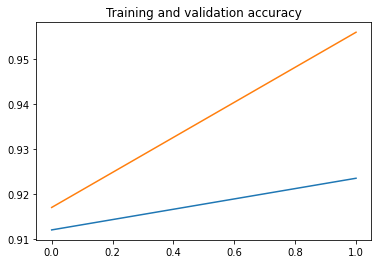

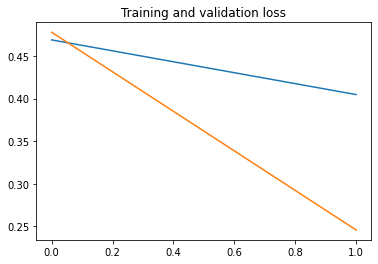

In [143]:
import matplotlib.pyplot as plt
import matplotlib.image as mipmg
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

#### Saving model and loading it:

In [144]:
#if os.path.isfile('CATS_DOGS_model.h5') is False:
#    model.save('CATS_DOGS_model.h5')

In [149]:
local_file_model = 'Cat_Dog_model.h5'
model = load_model(local_file_model)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              18875392  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 40,679,201
Trainable params: 18,876,417
Non-trainable params: 21,802,784
_________________________________________________________________


#### Loading Testing image

In [150]:
import numpy as np
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, load_img


test_file = r'C:\Users\w_alm\OneDrive\Documents\Python Scripts\Animal'
test_fnames = os.listdir(test_file)
print(test_fnames[:10])

['cat.0.jpg', 'cat.1.jpg', 'cat.2.jpg', 'dog.0.jpg', 'dog.1.jpg', 'dog.2.jpg']


Show the indices to show which value is cat and what value is dog:

In [151]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

Convert Amage to Array and Evaluate Test Data:

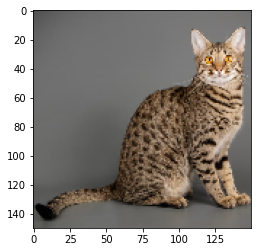

The image is a Dog


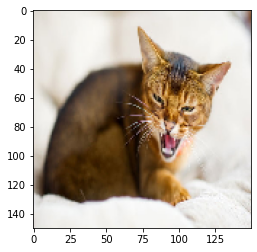

The image is a Cat


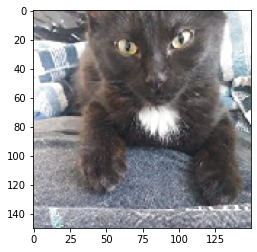

The image is a Cat


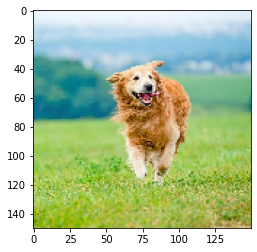

The image is a Dog


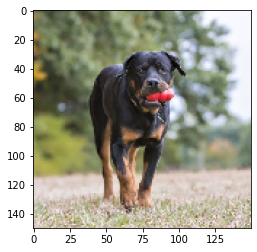

The image is a Dog


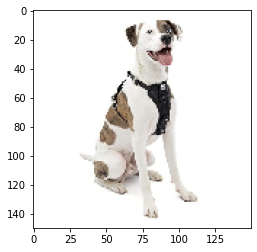

The image is a Cat


In [153]:
for i in os.listdir(test_file):
    img = image.load_img(test_file +'//' + i, target_size = (150, 150, 3))
    plt.imshow(img)
    plt.show()

    test = image.img_to_array(img)
    test = np.expand_dims(test, axis =0)
    test_images = np.vstack([test])
    test_evaluation = model.predict(test_images)
    if test_evaluation == 0:
        print('The image is a Cat')
    else:
        print('The image is a Dog')